In [8]:
# Import required libraries and set random seeds for reproducibility.
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import pydicom
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set random seeds for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print("✅ Imports done and random seeds set.")


✅ Imports done and random seeds set.


In [ ]:
# Load the RSNA Pneumonia CSV containing image IDs and labels.
labels_csv = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
df = pd.read_csv(labels_csv)
print("CSV Head:")
print(df.head())

# Build full file paths for each DICOM image.
# Assumes images are in 'stage_2_train_images' and named as {patientId}.dcm
train_images_folder = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/"
df["filepath"] = train_images_folder + df["patientId"] + ".dcm"

# Split the DataFrame into training and validation sets (80/20 split, stratified by Target)
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=seed_value, stratify=df["Target"]
)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")


In [ ]:
def load_dicom_image(path):
    # Convert the Tensor path to a Python string.
    path_str = path.numpy().decode("utf-8") if hasattr(path, "numpy") else path.decode("utf-8")
    
    # Read the DICOM file using pydicom
    dicom = pydicom.dcmread(path_str)
    img = dicom.pixel_array
    
    # Convert grayscale image to 3 channels if needed
    if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1)
    
    # Resize the image to 240x240 (model input size)
    img = cv2.resize(img, (240, 240))
    
    # Normalize pixel values to [0, 1]
    img = img.astype("float32")
    if np.max(img) != 0:
        img = img / np.max(img)
    return img

def process_path(path, label):
    # Wrap the load_dicom_image function for TensorFlow.
    img = tf.py_function(func=load_dicom_image, inp=[path], Tout=tf.float32)
    img.set_shape((240, 240, 3))
    return img, label

# Create validation dataset from the validation DataFrame.
val_paths = val_df["filepath"].values
val_labels = val_df["Target"].values.astype("float32")

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

print("✅ Validation dataset created successfully.")


In [ ]:
# Create training dataset from train_df (similar to validation)
train_paths = train_df["filepath"].values
train_labels = train_df["Target"].values.astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

print("✅ Training dataset created successfully.")


In [12]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model

def build_best_model():
    # Best hyperparameters from tuning:
    unfreeze = True
    dense_units = 64
    dropout_rate = 0.3
    lr = 0.00010733251249694184
    
    # Load DenseNet201 with ImageNet weights without the top classifier
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(240,240,3))
    base_model.trainable = unfreeze  # Unfreeze the base if True
    
    inputs = Input(shape=(240,240,3))
    # Pass inputs through the base model; use training=False to avoid updating BatchNorm stats inadvertently.
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

best_model = build_best_model()
best_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,444,993 (70.36 MB)

 Trainable params: 18,215,937 (69.49 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [13]:
# Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

EPOCHS = 10

history = best_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 803s 733ms/step - accuracy: 0.7941 - loss: 0.4363 - val_accuracy: 0.8348 - val_loss: 0.3644 - learning_rate: 1.0733e-04
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 385s 509ms/step - accuracy: 0.8371 - loss: 0.3542 - val_accuracy: 0.8012 - val_loss: 0.4157 - learning_rate: 1.0733e-04
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 382s 505ms/step - accuracy: 0.8677 - loss: 0.2962 - val_accuracy: 0.8060 - val_loss: 0.4367 - learning_rate: 1.0733e-04
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8981 - loss: 0.2284
Epoch 4: ReduceLROnPlateau reducing learning rate to 5.3666255553252995e-05.
756/756 ━━━━━━━━━━━━━━━━━━━━ 381s 504ms/step - accuracy: 0.8981 - loss: 0.2284 - val_accuracy: 0.8119 - val_loss: 0.5468 - learning_rate: 1.0733e-04
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 381s 504ms/step - accuracy: 0.9458 - loss: 0.1392 - val_accuracy: 0.8171 - val_loss: 0.5685 - learning_rate: 5.3666e-05
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 381s 5

In [14]:
val_loss, val_accuracy = best_model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accuracy: 0.8334 - loss: 0.3723
Validation Loss: 0.3644
Validation Accuracy: 0.8348


In [16]:
history_final=history

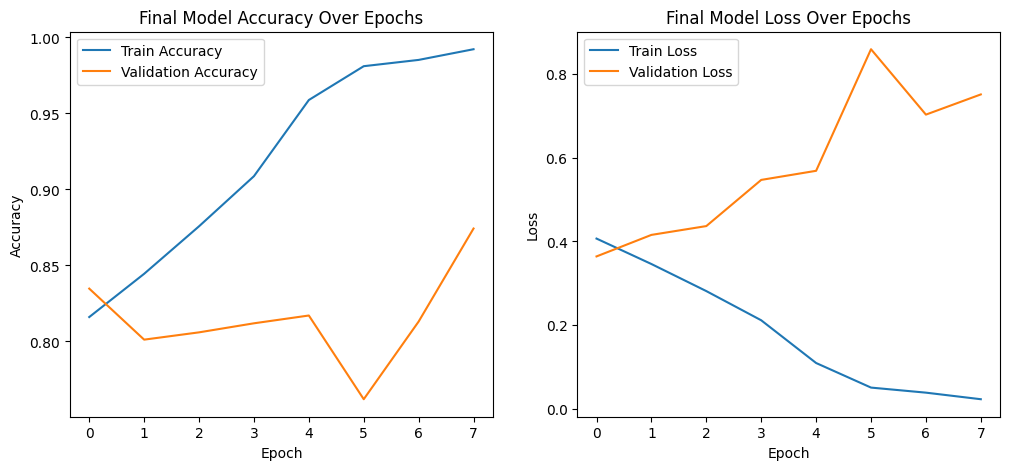

In [17]:
# Cell 12 (Optional): Visualize Training History

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accuracy: 0.8334 - loss: 0.3723
Validation Loss: 0.3644
Validation Accuracy: 83.48%
189/189 ━━━━━━━━━━━━━━━━━━━━ 67s 281ms/step

Confusion Matrix:
[[3549  586]
 [ 413 1498]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      4135
         1.0       0.72      0.78      0.75      1911

    accuracy                           0.83      6046
   macro avg       0.81      0.82      0.81      6046
weighted avg       0.84      0.83      0.84      6046

ROC-AUC Score: 0.91


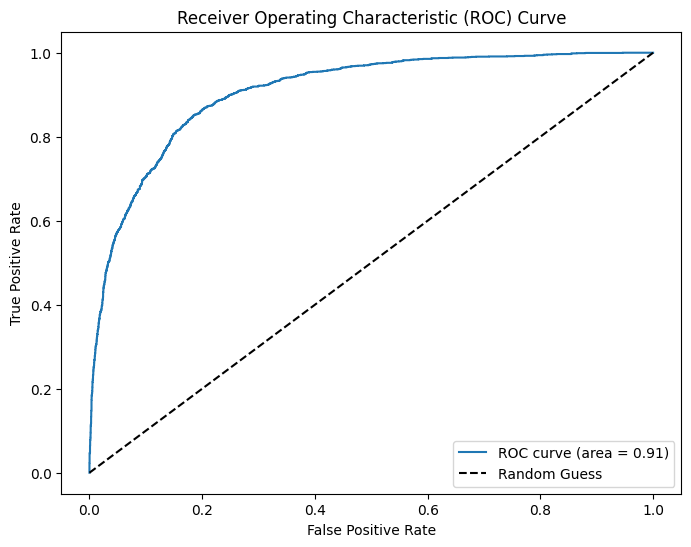

In [20]:
# Evaluate the model on the validation dataset
loss, accuracy = best_model.evaluate(val_ds)
print("Validation Loss: {:.4f}".format(loss))
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

# Import additional libraries for evaluation
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions from the model (y_pred_probs are probabilities)
y_pred_probs = best_model.predict(val_ds)
# Convert probabilities to class predictions (binary classification with threshold 0.5)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Retrieve true labels from the val_ds dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Compute and print the classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print("ROC-AUC Score: {:.2f}".format(roc_auc))

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


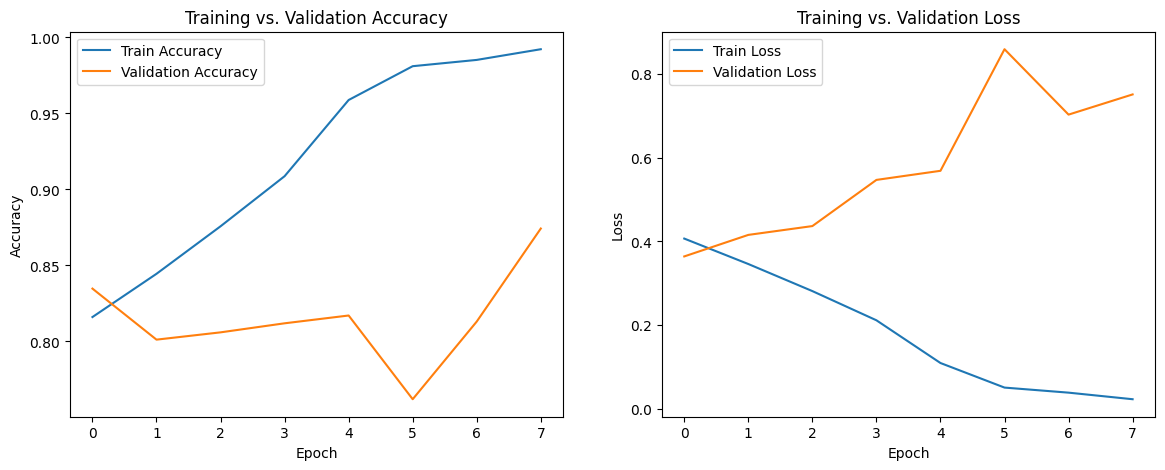

In [21]:
import matplotlib.pyplot as plt

# Replace 'history' with the variable name returned by model.fit() if different (e.g., history_final)
plt.figure(figsize=(14, 5))

# Plot Accuracy Curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
